<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-up-the-boundary-values" data-toc-modified-id="Set-up-the-boundary-values-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set up the boundary values</a></span></li><li><span><a href="#Set-up-the-diffusivity-matrix" data-toc-modified-id="Set-up-the-diffusivity-matrix-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Set up the diffusivity matrix</a></span></li><li><span><a href="#Steady-state-the-old-fashioned-way" data-toc-modified-id="Steady-state-the-old-fashioned-way-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Steady state the old-fashioned way</a></span></li><li><span><a href="#Repeat-the-steady-state-calculation-using-a-sparse-matrix" data-toc-modified-id="Repeat-the-steady-state-calculation-using-a-sparse-matrix-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Repeat the steady state calculation using a sparse matrix</a></span></li><li><span><a href="#Now-do-the-2d-problem" data-toc-modified-id="Now-do-the-2d-problem-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Now do the 2d problem</a></span><ul class="toc-item"><li><span><a href="#Set-up-the-problem-domain-and-build-A-and-b" data-toc-modified-id="Set-up-the-problem-domain-and-build-A-and-b-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Set up the problem domain and build A and b</a></span></li></ul></li><li><span><a href="#Compare-dense-and-sparse" data-toc-modified-id="Compare-dense-and-sparse-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Compare dense and sparse</a></span></li><li><span><a href="#Plot-your-saved-snapshots-on-a-grid" data-toc-modified-id="Plot-your-saved-snapshots-on-a-grid-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plot your saved snapshots on a grid</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Introducing sparse matrices

This is a rerun of the 2D_Transient_Assignment with two differences:

1. It imports common functions from a new python module called module_2D.py

1. It uses the scipy.sparse compressed storage format for rows (csr) with
   the sparse solver spsolve

In [1]:
import time

import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import numpy as np
from module_2D import Boundary_Def
from module_2D import build_2D_matrix
from module_2D import mat2vec
from module_2D import Problem_Def
from module_2D import vec2mat
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

It looks like I've been imported by another python script
My file location is: 
/Users/phil/repos/eosc213_students/notebooks/2D_Assignment_sparse/module_2D.py



## Set up the boundary values

In [2]:
c0 = 1  # mg/L

In [3]:
# Here we create 4 boundaries, west has a constant concentration at c0, east has a constant boundary at 0;
west = Boundary_Def("const", val=c0)
east = Boundary_Def("const", val=0)

# For 1D problem, the used boundaries are west and east.

# The other south and north boundaries have a zero flux (impermeable)

north = Boundary_Def("flux", val=0)
south = Boundary_Def("flux", val=0)

In [4]:
bc_dict = {"west": west, "north": north, "east": east, "south": south}
# The latter array bc_dict will be sent to the different functions

## Set up the diffusivity matrix

Going from 1 to 2 dimensions changes nothing conceptually. There are, however a couple of changes required for the coding perspective. Indeed, whether the problem is 1D or 2D or 3D, the stucture of the system of equation Ac = b is the same. Matrix $A$ will always be a $n \times n$ matrix, while $c$ and $b$ will always be column vector of size $n$. In 2D, $n = n_x \times n_y$, while in 3D, it will be $n = n_x \times n_y \times n_z$.  The individual equation for a cell still
produces a single row in the A and b matrices, but in 2D that cell has 4 neighbours instead
of 2, and 3D it has 6 neighbors intead of 4.

However, the fact is that in every case, the solution is stored in one vector, representing either a 1/2/3D solution. For these higher dimension problems, a two-way conversion between vector and matrix is required. To plot the 2D result, for example, we will use colourmap plots, which require the solution to be plotted to be represented as a 2D array (matrix).

The function vec2mat(...) (specifically $vector\ to\ matrix$) does this: it converts a vector into the relevant 2D matrix, using n_x and n_y.

The reverse function is usually required to initialize the initial condition. It is mac2vec(...). These two functions are defined here below.

In [5]:
decreasing_factor = 0.1  # Feel free to change if you want to see the impact
# (you can go higher than 1 ... But be careful, if diffusion speeds up significantly,
# the accuracy with respect to the chosen timestep might not be so good if you speed things up! )
# Initial value is 0.01

In [6]:
Diff = 2e-9 * 100 * 24 * 3600  # dm²/day

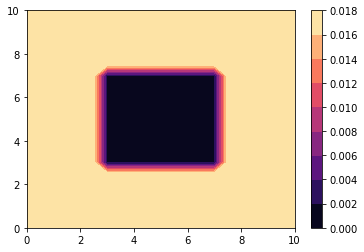

In [7]:
# Here we define the initial condition, and the diffusion matrix for the 2D problem


def make_D_matrix(the_problem, Diff, decreasing_factor):
    Diff_low = Diff * decreasing_factor
    n_x, n_y = the_problem.nx, the_problem.ny
    width_x, width_y = the_problem.wx, the_problem.wy
    D_matrix = Diff * np.ones((n_y, n_x))

    c_init = np.zeros((n_y, n_x))

    x = np.linspace(0, width_x, n_x)
    y = np.linspace(0, width_y, n_y)

    for i in range(n_y):
        for j in range(n_x):
            if j == 0:
                c_init[i, j] = c0  # Initial condition
    #
    # overwrite the center of the image with a low diffusivity
    #

    for i in range(n_y):
        for j in range(n_x):
            if (
                abs(x[j] - width_x / 2) <= 0.2 * width_x
                and abs(y[i] - width_y / 2) <= 0.2 * width_y
            ):
                D_matrix[i, j] = Diff_low
                # here we define a square of low diffusivity in the middle
    return x, y, D_matrix, c_init


width_x = 10  # dm
width_y = 10  # dm
n_x = 21
n_y = n_x
poro = 0.4

the_prob = Problem_Def(n_x, n_y, poro, width_x, width_y)
x, y, D_matrix, c_init = make_D_matrix(the_prob, Diff, decreasing_factor)
fig, ax = plt.subplots()
# This generates a colormap of diffusion.
cm = cmap.get_cmap("magma")
plt.contourf(x, y, D_matrix, cmap=cm)
plt.colorbar()

# "magma" refers to a colormap example. You can chose other ones
# https://matplotlib.org/examples/color/colormaps_reference.html

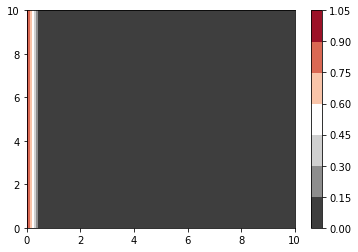

In [8]:
# Here we plot the initial condition using the colormap again
fig, ax = plt.subplots()
# This generates a colormap of diffusion.
cm = cmap.get_cmap("RdGy_r")
plt.contourf(x, y, c_init, cmap=cm)
plt.colorbar()

## Steady state the old-fashioned way

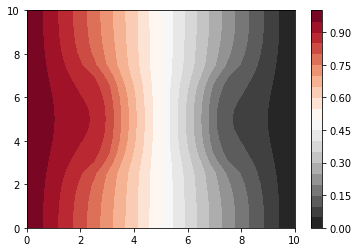

In [9]:
# Here we give you the asymptotic solution to the problem
# we are using everything we have done before

### Asymptotic behavior

Qsource = np.zeros((n_y, n_x))
A, b = build_2D_matrix(bc_dict, the_prob, D_matrix, Qsource)
v = np.linalg.solve(A, b)
n = n_x * n_y
# array v contains the solution
# we convert it in a matrix:

c = vec2mat(v, n_y, n_x)

# and we plot the matrix
plt.contourf(x, y, c, 20, cmap=cm)
plt.colorbar()

## Repeat the steady state calculation using a sparse matrix

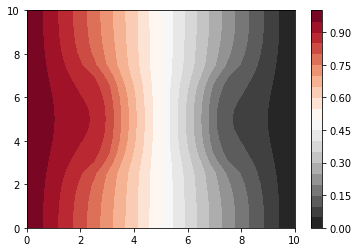

In [10]:
# Here we give you the asymptotic solution to the problem
# we are using everything we have done before

### Asymptotic behavior

poro = 0.4
prob = Problem_Def(n_x, n_y, poro, width_x, width_y)
Qsource = np.zeros((n_y, n_x))
A, b = build_2D_matrix(bc_dict, prob, D_matrix, Qsource)
A = csr_matrix(A, copy=True)

v = spsolve(A, b)
n = n_x * n_y
# # array v contains the solution
# # we convert it in a matrix:

c = vec2mat(v, n_y, n_x)

# # and we plot the matrix
plt.contourf(x, y, c, 20, cmap=cm)
plt.colorbar()

## Now do the 2d problem

As before, we will save a series of snapshots for plotting at different timesteps

In [11]:
dt = 1.0  #days
Tf = 2000.0  # days
number_of_fig = 9
plot_times = np.linspace(0, Tf, number_of_fig, dtype=np.int, endpoint=True)
plot_timesteps = (plot_times / dt).astype(np.int)
nTstp = int(Tf / dt)  # number of timesteps

### Set up the problem domain and build A and b

In [12]:
width_x = 10  # dm
width_y = 10  # dm
n_x = 25
n_y = n_x
n = n_x * n_y
poro = 0.4

the_prob = Problem_Def(n_x, n_y, poro, width_x, width_y)
x, y, D_matrix, c_init = make_D_matrix(the_prob, Diff, decreasing_factor)
Qsource = np.zeros((n_y, n_x))
A, b = build_2D_matrix(bc_dict, the_prob, D_matrix, Qsource)

## Compare dense and sparse

You should see about a factor of 6 speedup when you set 
`try_sparse = True`

In [13]:
try_sparse = False
v = mat2vec(c_init, n_y, n_x)
Adelta = np.zeros((n, n))
for i in range(n):
    Adelta[i, i] = poro / dt
Aa = A + Adelta
Bdelta = np.zeros(n)
if try_sparse:
    Aa = csr_matrix(Aa, copy=True)

save_figs = list()

clock_start = time.time()
fig_timesteps = []
fig_count = 0
for t in range(nTstp):
    capture_time = plot_timesteps[fig_count]
    for i in range(n):
        Bdelta[i] = v[i] * poro / dt
    bb = b + Bdelta
    if try_sparse:
        v = spsolve(Aa, bb)
    else:
        v = np.linalg.solve(Aa, bb)

    if t > capture_time:
        save_figs.append(vec2mat(v, n_y, n_x))
        fig_count += 1

clock_stop = time.time()
print(f"with try_sparse={try_sparse}, elapsed time is {clock_stop - clock_start}")

with try_sparse=False, elapsed time is 18.92159104347229


## Plot your saved snapshots on a grid

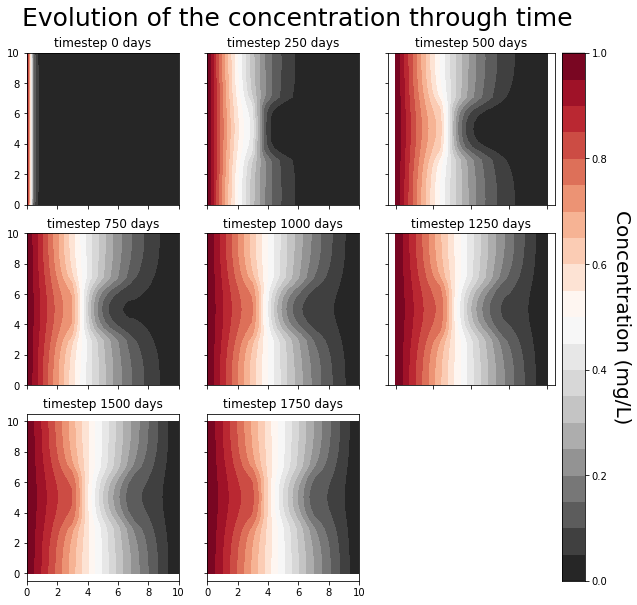

In [14]:
# https://jdhao.github.io/2017/06/11/mpl_multiplot_one_colorbar/
# https://matplotlib.org/tutorials/toolkits/axes_grid.html

automated_plot = True  # set that to False if you don't want the automated 9 plots
if automated_plot:
    fig = plt.figure(figsize=(10, 10))

    grid = AxesGrid(
        fig,
        111,
        nrows_ncols=(3, 3),
        axes_pad=0.40,
        cbar_mode="single",
        cbar_location="right",
        cbar_pad=0.1,
    )

    for fig_num, the_ax in enumerate(grid):
        the_ax.axis("equal")
        try:
            time_step = plot_times[fig_num]
            conc = save_figs[fig_num]
            im = the_ax.contourf(x, y, conc, 20, cmap=cm)
            the_ax.set_title(f"timestep {time_step} days")
        except IndexError:
            fig.delaxes(the_ax)

    cbar = grid.cbar_axes[0].colorbar(im)
    cbar.set_label_text("Concentration (mg/L)", rotation=270, size=20, va="bottom")
    fig.suptitle(
        "Evolution of the concentration through time", y=0.9, size=25, va="bottom"
    )
    fig.savefig("evolution.png")

##  Conclusions

What you may have noticed, is that, even for small simple 2d transient problems like the one you have just solved, the computation times are already becoming significant...

This is partly because we are dealing with big matrix which are filled with zeros. It is a complete waste of time and memory to deal with all of these 0 values. There are other ways to make our calculation way faster. We will probably dedicate a lecture to understand how we can improve this.